In [40]:
import os
import sys
import math
import pickle
from statistics import mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from sklearn.manifold import TSNE

sys.path.insert(0, '../../')

from source.statistics import wasserstein_distance


In [65]:
np.random.seed(15)
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.weight"] = "normal"
plt.rcParams["axes.labelweight"] = "normal"
plt.rcParams["axes.titleweight"] = "normal"

In [ ]:
test_set_directory = "../../test_set_distribution" # Path to the directory containing embeddings from test set
batch_directories = ["../../single_anchor_output"] # List of directories containing embeddings from examperiment
# batch_directories = ["../../2_or_more_anchors_output"]
# batch_directories = ["../../no_restrictions_output"]
embeddings = []
targets = []
predictions = []
for file_name in os.listdir(test_set_directory):
    if file_name.startswith("embeddings_batch_") and file_name.endswith(".npy"):
        batch_number = file_name.split("_")[2].split(".")[0]
        embeddings_batch = np.load(os.path.join(test_set_directory, f"embeddings_batch_{batch_number}.npy"))
        targets_batch = np.load(os.path.join(test_set_directory, f"targets_batch_{batch_number}.npy"), allow_pickle=True)
        with open(os.path.join(test_set_directory, f"predictions_batch_{batch_number}.pkl"), 'rb') as f:
            predictions_batch = pickle.load(f)
        embeddings.extend(embeddings_batch)
        targets.extend(targets_batch)
        predictions.extend(predictions_batch)

for batch_directory in batch_directories:
    for file_name in os.listdir(batch_directory):
        if file_name.startswith("embeddings_batch_") and file_name.endswith(".npy"):
            batch_number = file_name.split("_")[2].split(".")[0]
            embeddings_batch = np.load(os.path.join(batch_directory, f"embeddings_batch_{batch_number}.npy"))
            targets_batch = np.load(os.path.join(batch_directory, f"targets_batch_{batch_number}.npy"), allow_pickle=True)
            with open(os.path.join(batch_directory, f"predictions_batch_{batch_number}.pkl"), 'rb') as f:
                predictions_batch = pickle.load(f)
            embeddings.extend(embeddings_batch)
            targets.extend(targets_batch)
            predictions.extend(predictions_batch)
targets = np.array(targets, dtype=int)
embeddings = np.array(embeddings)

In [80]:
org_difference = []
masked_difference = []
crem_difference = []
diff_differences = []
crem_successes = 0
diff_successes = 0
no_predictions = 0
# Dictionary to map class indices to class names for embeddings
class_names = {0: 'Original',1: 'PubChem', 2: 'Zero features', 3: 'Crem', 4: 'DiffLinker'}


for idx,results in enumerate(predictions):
    if results["Org"] == []:
        no_predictions += 1
        continue
    if len(results[f"Diff_0"]) == 0 or len(results[f"Diff_1"]) == 0:
        diff_differences.append(math.nan)
    else:
        diff_differences.append(abs(mean(results[f"Diff_0"]) - mean(results[f"Diff_1"])))
        diff_successes += 1
    if len(results[f"Crem_0"]) == 0 or len(results[f"Crem_1"]) == 0:
        crem_difference.append(math.nan)
    else:
        crem_difference.append(abs(mean(results[f"Crem_0"]) - mean(results[f"Crem_1"])))
        crem_successes += 1
    
    org_difference.append(abs(results["Org"][0] - results["Org"][1]))
    masked_difference.append(abs(results["Masked"][0] - results["Masked"][1]))

sample_size = len(predictions) - no_predictions

print("Total number of predictions: ", sample_size)
print(f"\nNo Masking difference: {np.nanmean(org_difference)}")
print(f"\nZero features difference: {np.nanmean(masked_difference)}")
print(f"\nCremLinker difference: {np.nanmean(crem_difference)}")
print("Successs rate for CremLinker: ", (crem_successes) / sample_size)
print("Number of successes for CremLinker: ", crem_successes)
print(f"\nDiffLinker difference: {np.nanmean(diff_differences)}")
print("Successs rate for DiffLinker: ", (diff_successes) / sample_size)
print("Number of successes for DiffLinker: ", diff_successes)

Total number of predictions:  517

No Masking difference: 2.805233081763095

Zero features difference: 2.083862246408684

CremLinker difference: 1.6843346080328399
Successs rate for CremLinker:  0.8781431334622823
Number of successes for CremLinker:  454

DiffLinker difference: 1.8122913512911893
Successs rate for DiffLinker:  0.6711798839458414
Number of successes for DiffLinker:  347


In [71]:
print("Embeddings before undersampling:")
unique_targets, counts = np.unique(targets, return_counts=True)
target_counts = dict(zip(unique_targets, counts))

for target, count in target_counts.items():
    print(f"Target {target} ({class_names[target]}): {count} embeddings")

embeddings_all = np.copy(embeddings)
targets_all = np.copy(targets)

# Get the indices for each target
indices_target_2 = np.where(targets == 2)[0]
indices_target_3 = np.where(targets == 3)[0]
indices_target_4 = np.where(targets == 4)[0]

# Find the minimum count among targets 2, 3, and 4
min_count = min(len(indices_target_2), len(indices_target_3), len(indices_target_4))

# Randomly select indices for each target to match the minimum count
selected_indices_target_2 = np.random.choice(indices_target_2, size=min_count, replace=False)
selected_indices_target_3 = np.random.choice(indices_target_3, size=min_count, replace=False)
selected_indices_target_4 = np.random.choice(indices_target_4, size=min_count, replace=False)

# Get the indices for the other targets
indices_not_target_2_3_4 = np.where((targets != 2) & (targets != 3) & (targets != 4))[0]

# Combine all indices
undersampled_indices = np.concatenate([indices_not_target_2_3_4, selected_indices_target_2, selected_indices_target_3, selected_indices_target_4])

embeddings = embeddings[undersampled_indices]
targets = targets[undersampled_indices]
print("\nEmbeddings after undersampling:")
unique_targets, counts = np.unique(targets, return_counts=True)
target_counts = dict(zip(unique_targets, counts))

for target, count in target_counts.items():
    print(f"Target {target} ({class_names[target]}): {count} embeddings")

Embeddings before undersampling:
Target 0 (Original): 1990 embeddings
Target 1 (PubChem): 1276 embeddings
Target 2 (Zero features): 1276 embeddings
Target 3 (Crem): 278251 embeddings
Target 4 (DiffLinker): 12076 embeddings

Embeddings after undersampling:
Target 0 (Original): 1990 embeddings
Target 1 (PubChem): 1276 embeddings
Target 2 (Zero features): 1276 embeddings
Target 3 (Crem): 1276 embeddings
Target 4 (DiffLinker): 1276 embeddings


In [72]:
original_embeddings = embeddings[targets == 0]
pubchem_embeddings = embeddings[targets == 1]
zero_features_embeddings = embeddings[targets == 2]
crem_embeddings = embeddings[targets == 3]
diff_linker_embeddings = embeddings[targets == 4]

print(f"Wasserstein distance between Original and PubChem: {wasserstein_distance(original_embeddings, pubchem_embeddings)}")
print(f"Wasserstein distance between Original and Zero features: {wasserstein_distance(original_embeddings, zero_features_embeddings)}")
print(f"Wasserstein distance between Original and Crem: {wasserstein_distance(original_embeddings, crem_embeddings)}")
print(f"Wasserstein distance between Original and DiffLinker: {wasserstein_distance(original_embeddings, diff_linker_embeddings)}")

print(f"Wasserstein distance between PubChem and Zero features: {wasserstein_distance(pubchem_embeddings, zero_features_embeddings)}")
print(f"Wasserstein distance between PubChem and Crem: {wasserstein_distance(pubchem_embeddings, crem_embeddings)}")
print(f"Wasserstein distance between PubChem and DiffLinker: {wasserstein_distance(pubchem_embeddings, diff_linker_embeddings)}")

Wasserstein distance between Original and PubChem: 3.0349390643563314
Wasserstein distance between Original and Zero features: 48.73353172938702
Wasserstein distance between Original and Crem: 3.591130422230202
Wasserstein distance between Original and DiffLinker: 12.031167965567617
Wasserstein distance between PubChem and Zero features: 49.708363867572075
Wasserstein distance between PubChem and Crem: 1.6396354783244649
Wasserstein distance between PubChem and DiffLinker: 9.608704334212502


In [73]:
indexes_dict = {value: np.where(targets == value)[0].tolist() for value in np.unique(targets)}
tsne = TSNE(n_components=2, random_state=5, perplexity=70, learning_rate=180, n_iter=1000, early_exaggeration=12)
reduced_embeddings = tsne.fit_transform(embeddings)

reduced_embeddings_test = reduced_embeddings[indexes_dict[0]]
df_test = pd.DataFrame(reduced_embeddings_test, columns=['Dimension 1', 'Dimension 2'])
df_test['Samples'] = 'TestSet'

reduced_embeddings_crem = reduced_embeddings[indexes_dict[3]]

reduced_embeddings_diff = reduced_embeddings[indexes_dict[4]]

reduced_embeddings_zero = reduced_embeddings[indexes_dict[2]]

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(21, 7), sharex=True, sharey=True)

custom_legend = [
    Line2D([0], [0], color='blue', lw=6, alpha=0.5, linestyle='-', solid_capstyle='butt', label='Test set (Baseline)'),
    Line2D([0], [0], marker='o', markeredgecolor='red', markersize=9, markerfacecolor='none', linestyle='None', label='Feature zeroing'),
    Line2D([0], [0], marker='o', markeredgecolor='orange', markersize=9, markerfacecolor='none', linestyle='None', label='CM (DiffLinker)'),
    Line2D([0], [0], marker='o', markeredgecolor='green', markersize=9, markerfacecolor='none', linestyle='None', label='CM (CReM)'),
]

# Feature zeroing
sns.kdeplot(data=df_test, x='Dimension 1', y='Dimension 2', hue='Samples', fill=True, alpha=0.5, palette={"TestSet": "blue"}, ax=axes[0], legend=False)
axes[0].scatter(reduced_embeddings_zero[:, 0], reduced_embeddings_zero[:, 1], 
                marker='o', edgecolor='red', facecolor='none', linewidths=0.5)
wasserstein_dist_0 = wasserstein_distance(original_embeddings, zero_features_embeddings)
axes[0].text(0.95, 0.03, f"Wasserstein Distance: {wasserstein_dist_0:.2f}", transform=axes[0].transAxes, fontsize=24, verticalalignment='bottom', horizontalalignment='right')
# CM (DiffLinker)
sns.kdeplot(data=df_test, x='Dimension 1', y='Dimension 2', hue='Samples', fill=True, alpha=0.5, palette={"TestSet": "blue"}, ax=axes[1], legend=False)
axes[1].scatter(reduced_embeddings_diff[:, 0], reduced_embeddings_diff[:, 1], 
                marker='o', edgecolor='orange', facecolor='none', linewidths=0.5)
wasserstein_dist_1 = wasserstein_distance(original_embeddings, diff_linker_embeddings)
axes[1].text(0.95, 0.03, f"Wasserstein Distance: {wasserstein_dist_1:.2f}", transform=axes[1].transAxes, fontsize=24, verticalalignment='bottom', horizontalalignment='right')
# CM (CReM) 
sns.kdeplot(data=df_test, x='Dimension 1', y='Dimension 2', hue='Samples', fill=True, alpha=0.5, palette={"TestSet": "blue"}, ax=axes[2], legend=False)
axes[2].scatter(reduced_embeddings_crem[:, 0], reduced_embeddings_crem[:, 1], 
                marker='o', edgecolor='green', facecolor='none', linewidths=0.5)
wasserstein_dist_2 = wasserstein_distance(original_embeddings, crem_embeddings)
axes[2].text(0.95, 0.03, f"Wasserstein Distance: {wasserstein_dist_2:.2f}", transform=axes[2].transAxes, fontsize=24, verticalalignment='bottom', horizontalalignment='right')

subplot_labels = ['(A)', '(B)', '(C)']
for ax, label in zip(axes[:3], subplot_labels[:3]):
    ax.text(0.1, 0.98, label, transform=ax.transAxes,
            fontsize=24, va='top', ha='right')

x_min, x_max = -90, 90
y_min, y_max = -90, 90
for ax in axes:
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_aspect('equal', adjustable='box')

fig.legend(handles=custom_legend, loc='lower center', ncol=4, fontsize=24, frameon=False, bbox_to_anchor=(0.5, 0.0), handletextpad=0.3, columnspacing=0.7)

plt.subplots_adjust(wspace=0.05)

plt.savefig("embeddings_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

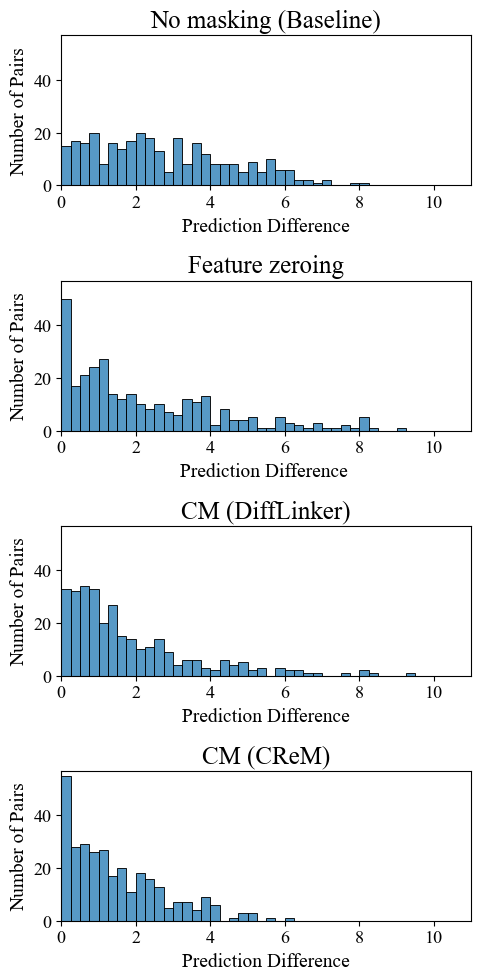

In [ ]:
plt.rcParams.update({'font.size': 13})

diff_arr = np.array(diff_differences)
crem_arr = np.array(crem_difference)
org_arr = np.array(org_difference)
masked_arr = np.array(masked_difference)

valid_indices = ~np.isnan(diff_arr) & ~np.isnan(crem_arr) & ~np.isnan(masked_arr) & ~np.isnan(org_arr)

org_valid = org_arr[valid_indices]
masked_valid = masked_arr[valid_indices]
diff_valid = diff_arr[valid_indices]
crem_valid = crem_arr[valid_indices]

fig, axes = plt.subplots(4, 1, figsize=(5, 10))

max_value = np.nanmax([
    np.nanmax(org_valid),
    np.nanmax(masked_valid),
    np.nanmax(diff_valid),
    np.nanmax(crem_valid)
])
max_value = math.ceil(max_value + 1)
bins = np.linspace(0, math.ceil(max_value), math.ceil(max_value)*4 + 1)

for ax in axes:
    ax.set_xlim([0, max_value])

max_y_value = max(
    np.histogram(org_valid, bins=bins)[0].max(),
    np.histogram(masked_valid, bins=bins)[0].max(),
    np.histogram(diff_valid, bins=bins)[0].max(),
    np.histogram(crem_valid, bins=bins)[0].max()
)
max_y_value = math.ceil(max_y_value + 2)

for ax in axes:
    ax.set_ylim([0, max_y_value])

sns.histplot(org_valid, bins=bins, ax=axes[0])
axes[0].set_title('No masking (Baseline)', fontsize=18)
axes[0].set_xlabel('Prediction Difference', fontsize=14)
axes[0].set_ylabel('Number of Pairs', fontsize=14)

sns.histplot(masked_valid, bins=bins, ax=axes[1])
axes[1].set_title('Feature zeroing', fontsize=18)
axes[1].set_xlabel('Prediction Difference ', fontsize=14)
axes[1].set_ylabel('Number of Pairs', fontsize=14)

sns.histplot(diff_valid, bins=bins, ax=axes[2])
axes[2].set_title('CM (DiffLinker)', fontsize=18)
axes[2].set_xlabel('Prediction Difference', fontsize=14)
axes[2].set_ylabel('Number of Pairs', fontsize=14)

sns.histplot(crem_valid, bins=bins, ax=axes[3])
axes[3].set_title('CM (CReM)', fontsize=18)
axes[3].set_xlabel('Prediction Difference', fontsize=14)
axes[3].set_ylabel('Number of Pairs', fontsize=14)

plt.tight_layout()
plt.savefig("prediction_difference_distribution_single.png", dpi=300, bbox_inches='tight')
plt.show()